In [552]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [553]:
timesteps = 30
epochs = 100
batch_size = 20
projectdaterange = 90

In [554]:
#to set up API - https://www.yahoofinanceapi.com/pricing
#data acquired from https://finance.yahoo.com/quote/TSLA?p=TSLA
df = pd.read_csv("TSLA.csv", sep = ',', header = 0)

# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
print(df)

            Date         Open         High          Low        Close  \
0     2017-01-11    45.813999    45.995998    45.335999    45.945999   
1     2017-01-12    45.812000    46.139999    45.116001    45.917999   
2     2017-01-13    46.000000    47.570000    45.917999    47.549999   
3     2017-01-17    47.340000    47.992001    46.874001    47.116001   
4     2017-01-18    47.330002    47.942001    47.116001    47.672001   
...          ...          ...          ...          ...          ...   
1255  2022-01-05  1146.650024  1170.339966  1081.010010  1088.119995   
1256  2022-01-06  1077.000000  1088.000000  1020.500000  1064.699951   
1257  2022-01-07  1080.369995  1080.930054  1010.000000  1026.959961   
1258  2022-01-10  1000.000000  1059.099976   980.000000  1058.119995   
1259  2022-01-11  1053.670044  1075.750000  1038.819946  1064.400024   

        Adj Close    Volume  
0       45.945999  18254000  
1       45.917999  18951000  
2       47.549999  30465000  
3       47.1160

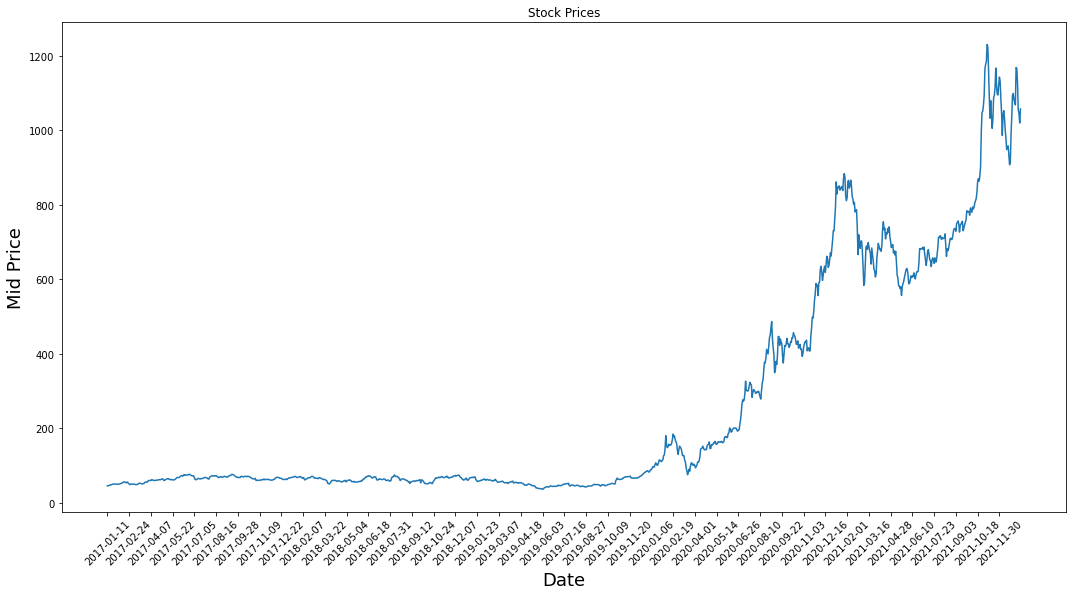

In [555]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['High']+df['Low'])/2)
plt.xticks(range(0,df.shape[0],30),df['Date'].loc[::30],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.title("Stock Prices")
plt.show()

# Proof of concept section

#### Splitting data into a training set and a test set

In [556]:
training_size = int(len(df)*0.8) #change 0.8 as needed to change training/test set sizes
data_len = len(df)

train_data, test_data = df[0:training_size], df[training_size:data_len]

print("Total data length --> ", data_len)
print("Train length --> ", len(train_data))
print("Test length --> ", len(test_data))

Total data length -->  1260
Train length -->  1008
Test length -->  252


#### Normalizing training data

In [557]:
# training data
train_data = train_data.loc[:, ["Open"]].values

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

end_len = len(train_scaled)
X_train = []
y_train = []

for i in range(timesteps, end_len):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train shape --> ", X_train.shape)
print("y_train shape --> ", y_train.shape)

X_train shape -->  (978, 30, 1)
y_train shape -->  (978,)


#### Create, compile, and fit model

In [ ]:
#create model
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

#compile model
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

#fit model
regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0056
Epoch 2/100
49/49 [==============================] - 4s 75ms/step - loss: 0.0021
Epoch 3/100
49/49 [==============================] - 4s 74ms/step - loss: 0.0030
Epoch 4/100
49/49 [==============================] - 4s 74ms/step - loss: 0.0016
Epoch 5/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0014
Epoch 6/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0016
Epoch 7/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0016
Epoch 8/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0012
Epoch 9/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0013
Epoch 10/100
49/49 [==============================] - 4s 76ms/step - loss: 0.0014
Epoch 11/100
49/49 [==============================] - 4s 74ms/step - loss: 0.0011
Epoch 12/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0016
Epoch 13/100
49/49 [=====

##### Test the model

In [ ]:
print(test_data.head())

In [ ]:
real_price = test_data.loc[:, ["Open"]].values
print("Real Price Shape --> ", real_price.shape)

In [ ]:
dataset_total = df["Open"]
inputs = dataset_total[len(dataset_total) - len(test_data) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)
print(inputs.shape)

In [ ]:
X_test = []

for i in range(timesteps, ((len(real_price))+timesteps)):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test, dtype=object)

print("X_test shape --> ", X_test.shape)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = np.asarray(X_test).astype(np.float32)
print("X_test shape --> ", X_test.shape)

predict = regressor.predict(X_test)
predict = scaler.inverse_transform(predict)
print(predict.shape)

##### Visualizing predictions

In [ ]:
testdays = list(test_data.index.values)

plt.figure(figsize = (18,9))
plt.plot(train_data, color = "blue", label = "Training Data")
plt.plot(testdays, real_price, color = "red", label = "Real Test Data")
plt.plot(testdays, predict, color = "black", label = "Predicted Test Data")
plt.title("Stock Price Prediction Model Validation")
plt.xlabel("Days")
plt.ylabel("Price")
plt.xticks(range(0, data_len, 30), rotation=45)
plt.legend()
plt.show()

# Future predictions

In [ ]:
#normalizing training data
train_dataall = df.loc[:, ["Open"]].values
trainall_scaled = scaler.fit_transform(train_dataall)

end_lenall = len(trainall_scaled)
X_trainall = []
y_trainall = []

for i in range(timesteps, end_lenall):
    X_trainall.append(trainall_scaled[i - timesteps:i, 0])
    y_trainall.append(trainall_scaled[i, 0])
X_trainall, y_trainall = np.array(X_trainall), np.array(y_trainall)

X_trainall = np.reshape(X_trainall, (X_trainall.shape[0], X_trainall.shape[1], 1))
print("X_train shape --> ", X_trainall.shape)
print("y_train shape --> ", y_trainall.shape)

In [ ]:
#fit model
regressor.fit(X_trainall, y_trainall, epochs = epochs, batch_size = batch_size)

In [ ]:
allinputs = dataset_total[len(dataset_total) - timesteps:].values.reshape(-1,1)
allinputs = scaler.transform(allinputs)
print(allinputs.shape)

In [ ]:
recentpastprice = []

for i in range(timesteps, (projectdaterange+timesteps)):
    recentpastprice.append(inputs[i-timesteps:i, 0])
recentpastprice = np.array(recentpastprice, dtype=object)

print("Recent past prices shape --> ", recentpastprice.shape)

In [ ]:
recentpastprice = np.reshape(recentpastprice, (recentpastprice.shape[0], recentpastprice.shape[1], 1))
recentpastprice = np.asarray(recentpastprice).astype(np.float32)

futurepredict = regressor.predict(recentpastprice)
futurepredict = scaler.inverse_transform(futurepredict)

print('Over the next', projectdaterange, 'days, the highest price will be', max(futurepredict), 'around day', list(futurepredict).index(max(futurepredict)))
print('Over the next', projectdaterange, 'days, the lowest price will be', min(futurepredict), 'around day', list(futurepredict).index(min(futurepredict)))

In [ ]:
predictdays = list(range((1 + data_len), (projectdaterange + 1 + data_len)))

plt.figure(figsize = (18,9))
plt.plot(train_dataall, color = "blue", label = "Past prices")
plt.plot(predictdays, futurepredict, color = "black", label = "Predicted prices")
plt.title("Stock Price Predictions")
plt.xlabel("Days from now")
plt.ylabel("Price")
plt.xticks(range(0, (data_len + projectdaterange), 30), rotation=45)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(futurepredict, color = "black", label = "Predictions")
plt.title("Stock Price Predictions Close-up")
plt.xlabel("Days from now")
plt.ylabel("Price")
plt.legend()
plt.show()